# Pipeline vs FastICA: Performance Comparison in Fetal ECG Extraction

This notebook compares a model-based, sequential signal processing pipeline with a blind source separation approach based on FastICA for non-invasive fetal ECG extraction from abdominal recordings.

The proposed pipeline exploits physiological knowledge, while FastICA relies solely on statistical independence assumptions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import wfdb

import pandas as pd
from modules import utils, function
from modules.cleaning import baseline_wander_removal, powerline_interference_canceller, upsample_to_2kHz
from modules.qrsdetection import detect_mQRS, detect_fQRS
from modules.mecgcanceller import mecg_canceller
from modules.fecgextraction import FECG_avg
from modules.metrics import compute_metrics, compute_snr_sir_martens, calculate_paper_metrics

from modules import fastICA
from modules.fastICA import run_fastica_all_channels, compare_martens_vs_ica



In [3]:
record = wfdb.rdrecord("./dataset/set-a/a04")
true_qrs = np.loadtxt("./dataset/set-a-text/a04.fqrs.txt")

X = record.p_signal
fs = record.fs
print(X.shape)

(60000, 4)


# PIPELINE

In [4]:
S2 = baseline_wander_removal(X, fs)
S3 = powerline_interference_canceller(S2, fs)
S4, fs_up = upsample_to_2kHz(S3, fs)
mQRS_clean, PC1_maternal_clean, corr_maternal_clean, maternal_template_clean = detect_mQRS(S4, fs_up)
print("Detected maternal QRS:", len(mQRS_clean))
S4_pre = S4.copy()
# iterative MECG cancellation
for i in range(3):
    S4 = mecg_canceller(S4, mQRS_clean, fs_up, N=30)

S5 = S4
S4 = S4_pre
clean_fQRS, PC1_f, corr_f, tmpl_f = detect_fQRS(S5, fs_up )
print("Fetal QRS detected:", len(clean_fQRS))

Detected maternal QRS: 80
Fetal QRS detected: 129


In [5]:
def compute_FHR(fQRS, fs_up):
    fQRS = np.array(fQRS)
    RR = np.diff(fQRS) / fs_up  # sec
    FHR = 60 / RR               # bpm
    return FHR

FHR = compute_FHR(clean_fQRS, fs_up)
print("Fetal: ",np.mean(FHR).round(2), "bpm")

FHR = compute_FHR(mQRS_clean, fs_up)
print("Mum:",np.mean(FHR).round(2),"bpm")

Fetal:  130.21 bpm
Mum: 80.03 bpm


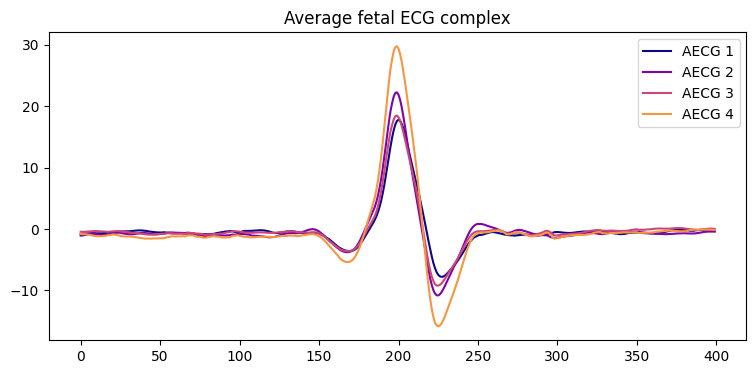

(400, 4)

In [6]:
S6 = FECG_avg(S5, clean_fQRS, fs_up)
S6.shape

In [7]:
RR = np.diff(clean_fQRS) / fs_up
HR = 60 / RR


In [8]:
true_qrs_samples_up = (true_qrs * 2).astype(int)

In [9]:
reliability, mean_bpm, is_successfull = calculate_paper_metrics(clean_fQRS, fs_up, S5.shape[0])

In [10]:
SNR_dB, SIR_dB = compute_snr_sir_martens(S4_pre, S5, S6, clean_fQRS, fs_up)

In [11]:
def compute_RR_from_peaks(fQRS, fs):
    fQRS = np.array(fQRS)
    RR_samples = np.diff(fQRS)
    RR_seconds = RR_samples / fs
    return RR_seconds

def compute_FHR(RR_seconds):
    return 60.0 / RR_seconds

RR = compute_RR_from_peaks(clean_fQRS, fs_up)
FHR = compute_FHR(RR)

In [12]:
def resample_FHR(FHR, fs_fhr=4):
    n = len(FHR)
    t_original = np.cumsum(np.ones(n))  
    t_original = t_original / 2        
    return FHR  
FHR = resample_FHR(FHR, fs_fhr=4)


# Comparison: Implementation ICA - FAST ICA

In [13]:
S_ica = run_fastica_all_channels(S3)   

results = compare_martens_vs_ica(
    qrs_martens = clean_fQRS,
    qrs_true = true_qrs_samples_up,
    S_ica = S_ica,
    fs_up = fs_up,
    qrs_detector = fastICA.qrs_detector_simple_fetal,
    HR = HR,
    reliability = reliability
)


=== ICA ===
Best fetal component: 1
QRS ICA: 80
Mean FHR ICA: 162.54747960024693
Reliability ICA: 0.5696202531645569

=== PIPELINE ===
QRS Pipeline: 129
Mean FHR Pipeline: 130.2104378557717
Reliability Pipeline: 0.9453125

=== QRS ERROR VS REAL ===
ICA     → MAE: 113.11 ms | RMSE: 132.91 ms | Reliability(dist): 0.15
PIPELINE → MAE: 3.67 ms | RMSE: 12.52 ms | Reliability(dist): 0.99


# All Dataset Comparison

In [14]:
dfa = pd.read_csv("./result/comparison.csv")

In [15]:
fastICA.mean_metrics_ica(dfa)


## 1. Global Performance(Mean and Dev. Std)
                 Global Mean  Global Dev. Std
ica_rel               0.5511           0.1764
reliability           0.6675           0.2268
mean_bpm_f          128.9513          13.5248
mean_real_bpm_f     136.3536          14.6817
sir_gain_dB           8.9241           1.6271
fSNR_dB               8.1851           2.0838
SIR                  -3.9307           3.9619
SNR                  -8.4023           6.0698
SE                    0.6326           0.3538
PPV                   0.6878           0.3101
F1                    0.6548           0.3370
ACC                   0.5737           0.3630
TP                   82.6400          43.8091
FP                   31.4800          29.9139
FN                   52.9600          53.4895

--- Analysis 2: Group using isSuccess ---

## 2. Comparison between SUCCESS & FAIL
                ica_rel  reliability  mean_bpm_f  mean_real_bpm_f  \
FAIL (False)     0.5114       0.4339    124.5833         146.8435 

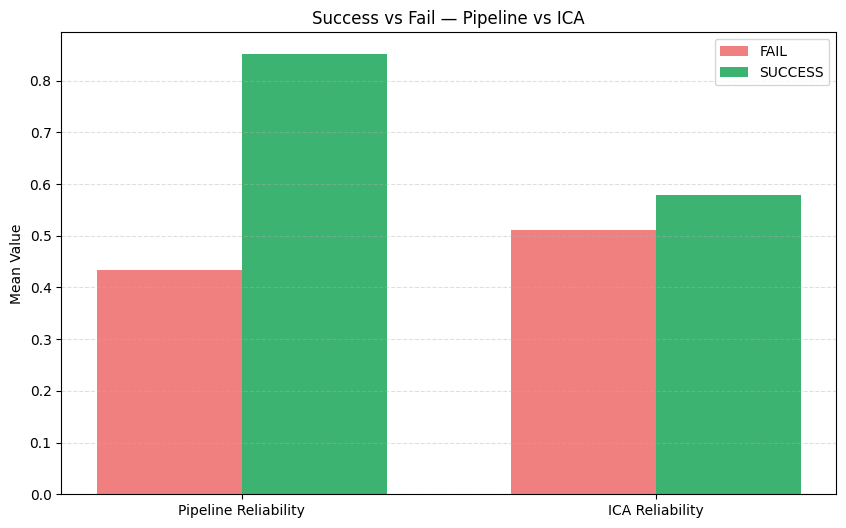

SUCCESS means:
 reliability    0.851016
ica_rel        0.579477
dtype: float64

FAIL means:
 reliability    0.433920
ica_rel        0.511409
dtype: float64


In [16]:
function.plot_success_fail_means(dfa)

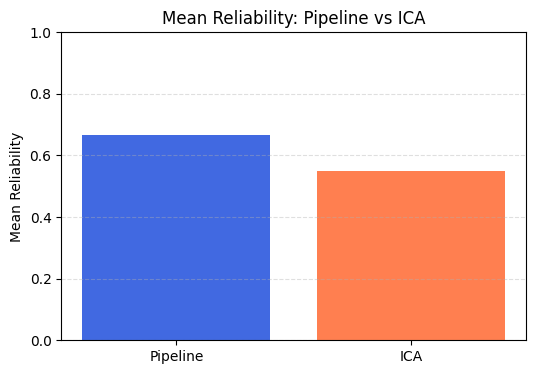

Mean Pipeline reliability: 0.6674933244330442
Mean ICA reliability: 0.5511152102253063


In [17]:
fastICA.plot_reliability_means(dfa)

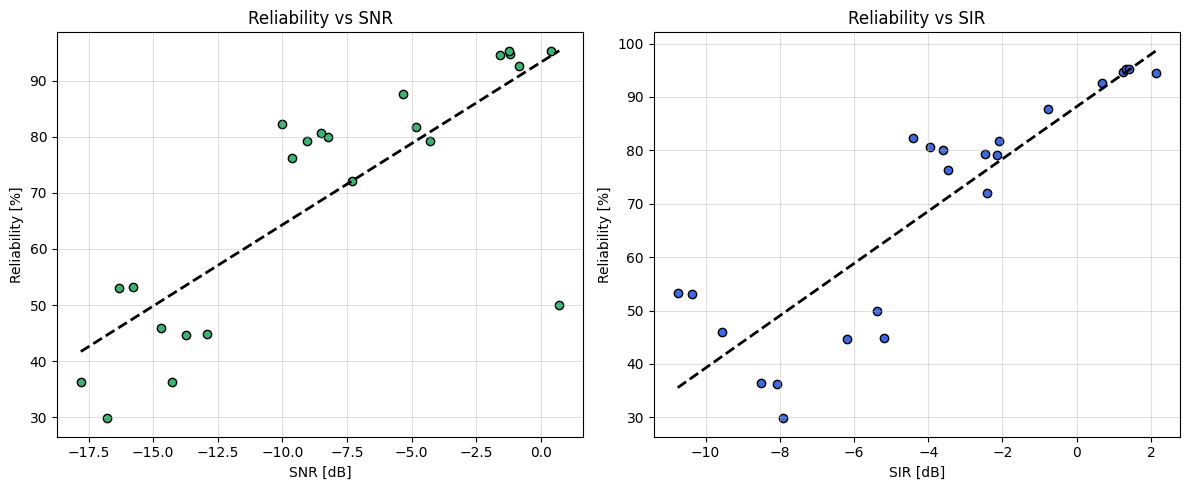

In [24]:
function.plot_reliability_vs_snr_sir(dfa)

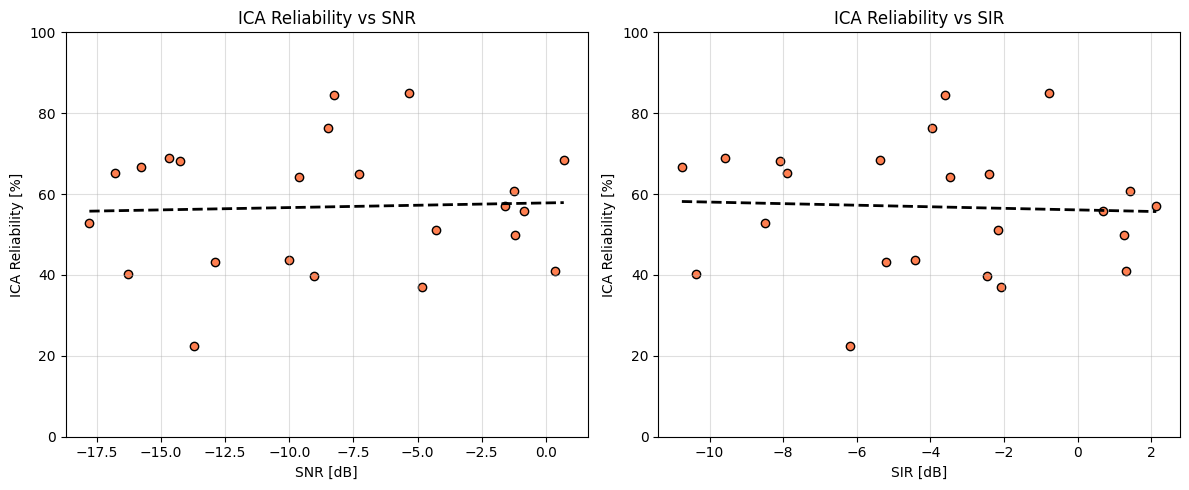

In [25]:
function.plot_ica_reliability_vs_snr_sir(dfa)